In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics.pairwise import *
from sklearn.cluster import *
import scipy as sp
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [ ]:
def text_file_retrieve(path):
    with open(path) as f:
        lines = [line.split() for line in f]
    f.close()
    return lines

In [ ]:
def compute_gaussian_matrix(data, sigma):
    gmatrix = np.matrix(np.full((data.shape[0], data.shape[0]), 0, dtype=float))
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
          delta = np.matrix(abs(np.subtract(data[i, :], data[j, :])))
          sq_euc = (np.square(delta).sum(axis=1))
          gmatrix[i, j] = np.exp(-(sq_euc)/(2*sigma**2))

          #gmatrix[i, j] = gaussian_kernel(data[i, :], data[j, :], sigma)
    return gmatrix

In [ ]:
def spectral_clustering(data, n_clusters, sigma, clusters):
    data_gene = data[:, 0]
    data_gt = data[:, 1]
    data_x = np.array(data[:, 2:], dtype=float, copy=False)
    gaussian_matrix = compute_gaussian_matrix(data_x, sigma)
    degree_matrix = np.diag(gaussian_matrix.sum(axis=1))
    laplacian_matrix = degree_matrix - gaussian_matrix
    spectral_embedding = convert_to_spectral(laplacian_matrix, n_clusters)
    if len(clusters) == 0:
        model = KMeans(n_clusters=n_clusters, random_state=0)
        model.fit(spectral_embedding)
        predictions = model.labels_
    else:
        model = KMeans(n_clusters=n_clusters, init=clusters)
        model.fit(spectral_embedding)
        predictions = model.labels_
    pca_plotting(data_x, predictions)
    act_neg, act_pos, pred_pos, pred_neg = confusion_matrix(data_gt, predictions, data_x)
    jac = act_pos / (act_pos + pred_pos + pred_neg)
    rand = (act_pos + act_neg) / (act_pos + act_neg + pred_pos + pred_neg)
    print('Jaccard Coefficient: ', round(jac, 3))
    print('Rand Index: ', round(rand, 3))

In [ ]:
def convert_to_spectral(laplacian_matrix, n_clusters):
    eig_val, eig_vec = sp.linalg.eig((laplacian_matrix))
    ind = eig_val.real.argsort()[:n_clusters]
    lmatrix = np.ndarray(shape=(laplacian_matrix.shape[0], 0))
    for i in range(1, ind.shape[0]):
        vec = np.transpose(np.matrix(eig_vec[:, np.asscalar(ind[i])]))
        lmatrix = np.concatenate((lmatrix, vec), axis=1)
    return lmatrix

In [ ]:
def pca_plotting(data_x, predictions):
    pca = PCA(n_components=2).fit_transform(data_x)
    pred_uni = list(set(predictions))
    uni_names = []
    colours_unique_vector = cm.Set1(np.linspace(0, 1, len(pred_uni)))
    for i in range(len(pred_uni)):
        rows_index = np.where(predictions == pred_uni[i])
        rows = pca[rows_index]
        x_plot = [rows[:, 0]]
        y_plot = [rows[:, 1]]
        uni_names.append(plt.scatter(x_plot, y_plot, c=colours_unique_vector[i]))
    plot_unique_labels = [-1.0 if x == 0 else x for x in pred_uni]
    plot_unique_labels = np.array(plot_unique_labels, dtype=int)
    plt.legend(uni_names, plot_unique_labels, loc="best", ncol=1, markerfirst=True, shadow=True)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Spectral clustering visualization", fontweight="bold")
    plt.show()

In [ ]:
def confusion_matrix(actual, predicted, data_x):
    act_neg, act_pos, pred_pos, pred_neg = 0, 0, 0, 0
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[0]):
            if actual[i] == actual[j]:
                if predicted[i] == predicted[j]:
                    act_pos = act_pos + 1
                else:
                    pred_neg = pred_neg + 1
            elif actual[i] != actual[j]:
                if predicted[i] == predicted[j]:
                    pred_pos = pred_pos + 1
                else:
                    act_neg = act_neg + 1
    return act_neg, act_pos, pred_pos, pred_neg

Enter the filename: /content/cho.txt
Enter the number of Clusters: 10
Enter the sigma value: 1.5
Enter the clusters points (if not then press ENTER): 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

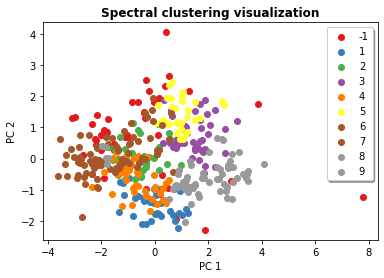

Jaccard Coefficient:  0.166
Rand Index:  0.763


In [ ]:
def main():
    text_file_name = input("Enter the filename: ")
    lines = text_file_retrieve(text_file_name)
    data = np.asarray(lines)
    n_clusters = int(input("Enter the number of Clusters: "))
    sigma = float(input("Enter the sigma value: "))
    clusters = input('Enter the clusters points (if not then press ENTER): ')
    if clusters == '':
        clusters = []
    else:
        clusters = clusters.split(', ')
    spectral_clustering(data, n_clusters, sigma, clusters)

main()